In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'glove-embeddings:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F870709%2F1483651%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240131%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240131T143529Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dab1ee7ab1165a1d9e3bb55372e2b14f02e73fb1dbf162c61cf859082b14e796bcb73279a698e3ef6f0e85ff46581fbf8668cec5825003ae7d426315e4d95c7762be989b40cc75f67fbbf086e4c9d0d83f2770c56e41db6746b99665b88568c00bbcc0bf661173ef61c66e177541f53de017f24ae7314d65588d11e80ed132eb2f8e00e197124962b64e83da756d597bd4c39b8e8f30f1d13e66cfb20c326958e68ca7fe472ec8fff970924a7febf05fbaf0ef56d5eddd95bd38ff2f996eec187bcda680311093056e78d73ca37dc97716989b35838a4bc80cc497e7dddd9da21b3cf9ea8be0563da338c21a3c3e0d6960e87561c72dd334e13f6543ed681d112,flikr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3231714%2F5620362%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240131%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240131T143530Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D38722dae6dedb57eeead3b3d5775c1cfa5a6eb004da49d9d52c1a1a9e6dbc47595adcd2a7a948682dd88b3fa0cd7df27ce2281c5715cb04021e30746eff4e3049a9189999a0a29f42fe5309f969d5d95179b5835b37a44ed9ca2308225e61f321460835e00ca62c9058e3c5cad1a793805dea90e69f2abc96da4b62a525476a8aba00d91fd31a554c5596dac9ad8e1ca2d7ba5c32f876a9c6d20dd8c5b67a8b5087d7c70b19c8cd45a20fd00ae89c514de43ab8288c09a1b5f11a83f6c562668f7cc3ff66bd46f338ff20a41e733efda670b3ef8c7fd9822e2a720185cf7b0cd0f09adaaf1207d217aa18a48c2c4e8e65991f723e07dad2cfc5d6ecfd865e7ce,encoded-features:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4361939%2F7491761%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240131%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240131T143530Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D20d7331e30dc88e9c377300f0d3e46a63f56901f52a32923252767e24fab6d09171514d001bf0c0dde50da07b1eed634ece3aaad9aebf8b1fb498506ef48f267bf66fcbcbb3a5105b3e1050787b8b4bdea485b45e0be6292cf6b43d18011b0851688673e678de37ec83e29fd479a77e7ca983889c0e4e396e51bac9292e298365497d30f7422cf6068d5e5c492805581a20861ca37808bd838ef171939e2ff87455063431a50a6a9487fcc533d4791657cd96041d8ca1d1c15eabda310f29379d6021363c65df57b4e09f63190ee9cc178c40101320fd7d87ef74f3ce72fbd7bde5a8db601286f60da10ed4de383b40da073c77cf9a9d816cd510ea643e275cd,trained-model:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4362255%2F7492215%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240131%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240131T143530Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D63c535c100e1410f89a650708163facee6870290ff0aa0ae339681a669e539f13ba541398698408e1ae5f89a785bea62deb957f8d0a46c7d74f7027c9cec18d7331a9e418713b8d138aadac3ce40941a8d5d7f7508253633b5bf4cb66218a4b15de287e710122c0e4b2247f451fa6c35697ef94fb330b67963260eca07a3c1753d58a8d3cabfbd7375208f5ffc5bcdcaec22a54cb1d5f88cfc3da03baa8463e7bd687a2da1fda4cb45aebc3a3ebd81f9031c77460af43851b6b30f93833471ccef2b595426170b86ae9f188138bb072ee848ce225d9e55deae86b63f06f4495b902240f3fd5cc8a15602bce43eb4cec1361b27c595ffc5b6a23b2c2aaf0e787e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 885020669 bytes downloaded
Downloaded and uncompressed: glove-embeddings
[==================================================] 1114238055 bytes downloaded
Downloaded and uncompressed: flikr8k
[==================================================] 50506061 bytes downloaded
Downloaded and uncompressed: encoded-features
[==================================================] 12907526 bytes downloaded
Downloaded and uncompressed: trained-model
Data source import complete.


# TABLE:

**Libraries and Initializations**
> - Import necessary libararies
> - Path initialization of dataset input

**Text processing**
> - Parse token.txt file **[img.jpg#d token_text]** format.
> - Parsing dictionary **{ img : [caption1, caption2, caption3, caption4, caption5] }**
> - Preprocess captions

**Vocabulary setup**
> - Create word vocabulary

**Train/Test Images**
> - Collect train/test images
> - Process training images: [ captions ]

**Models**
> - Initialize ResNet50 model
> - Collect feature_vectors for train/test images

**Embeddings**
> - Initialize glove-embeddings/glove.6B.50d.txt
> - Create Embedding matrix for vocab

**Models updation**
> - Initialize hierarchichal model for image and text training
> - Create custom data generator

**Training/Testing**
> - Train model with image and captions
> - Model testing

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import re
import keras
from time import time

from keras.layers import add, Dense, Input, Dropout, Embedding, LSTM
from keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords

In [ ]:
token_txt_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr8k.token.txt'
train_img_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt'
test_img_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt'

images_path = '/kaggle/input/flikr8k/Flickr8K/Flicker8k_Images/'

In [ ]:
def ReadTextFile(file):
    with open(file) as f:
        captions = f.read()
    return captions

captions = ReadTextFile(token_txt_path)
captions = captions.split('\n')[:-1]

print(len(captions))
print(captions[0])

40460
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


# Dictionary to map each image to its corresponding token texts.

In [ ]:
img_descriptions = {}

def imageWithText(captions):
    for d in captions:
        image_name, caption = d.split('\t')
        image_name = image_name.split('.')[0]

        if img_descriptions.get(image_name) is None:
            img_descriptions[image_name] = []

        img_descriptions[image_name].append(caption)


imageWithText(captions)
del(img_descriptions['2258277193_586949ec62'])

8091
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


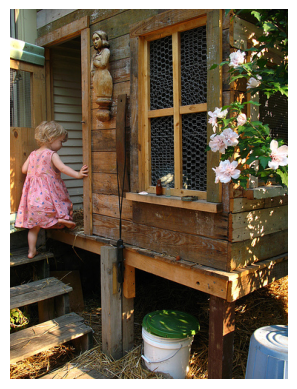

In [ ]:
print(len(img_descriptions))
print(img_descriptions['1000268201_693b08cb0e'])

img = images_path + '1000268201_693b08cb0e.jpg'
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# checking if any of the image in token.txt images is not existing in 8k_images

# for t in img_descriptions.keys():
#     p = os.path.join(images_path, t + '.jpg')
#     if not os.path.isfile(p):
#         print(t)

In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+', " ", sentence)
    sentence = sentence.split()

    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

# clean_text("A cat is sitting in room no hello64")

for k, caption_list in img_descriptions.items():
    for c in range(len(caption_list)):
        caption_list[c] = clean_text(caption_list[c])

print(img_descriptions['1000268201_693b08cb0e'])

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [ ]:
with open('/kaggle/working/descriptions.txt', 'w') as f:
    f.write(str(img_descriptions))

In [ ]:
descriptions = {}

with open('/kaggle/working/descriptions.txt', 'r') as f:
    descriptions = f.read()

descriptions = json.loads(descriptions.replace("'", "\""))

In [ ]:
vocab = set()
for k in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[k]]

print(len(vocab))

8424


In [ ]:
Total_words = []

for k in descriptions.keys():
    [Total_words.append(i) for sentence in descriptions[k] for i in sentence.split()]

print(len(Total_words))

373803


In [ ]:
import collections

counter = collections.Counter(Total_words)
freq_count = dict(counter)
# print(freq_count)
print(len(freq_count))

8424


In [ ]:
sorted_freq_cnt = sorted(freq_count.items(), reverse=True, key=lambda x: x[1])

threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]
Total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
len(Total_words)

1845

In [ ]:
train_file_data = ReadTextFile(train_img_path)
test_file_data = ReadTextFile(test_img_path)

In [ ]:
train = [r.split('.')[0] for r in train_file_data.split("\n")[:-1]]
test = [r.split('.')[0] for r in test_file_data.split("\n")[:-1]]

In [ ]:
len(train), len(test), train[:10], test[:10]

(6000,
 1000,
 ['2513260012_03d33305cf',
  '2903617548_d3e38d7f88',
  '3338291921_fe7ae0c8f8',
  '488416045_1c6d903fe0',
  '2644326817_8f45080b87',
  '218342358_1755a9cce1',
  '2501968935_02f2cd8079',
  '2699342860_5288e203ea',
  '2638369467_8fc251595b',
  '2926786902_815a99a154'],
 ['3385593926_d3e9c21170',
  '2677656448_6b7e7702af',
  '311146855_0b65fdb169',
  '1258913059_07c613f7ff',
  '241347760_d44c8d3a01',
  '2654514044_a70a6e2c21',
  '2339106348_2df90aa6a9',
  '256085101_2c2617c5d0',
  '280706862_14c30d734a',
  '3072172967_630e9c69d0'])

In [ ]:
demo_img = '2513260012_03d33305cf'

In [ ]:
train_descriptions = {}
for t in train:
    train_descriptions[t] = []
    for sent in descriptions[t]:
        sent = 'startseq ' + sent + ' endseq'
        train_descriptions[t].append(sent)

Total_words.append('startseq')
Total_words.append('endseq')
print(train_descriptions['2513260012_03d33305cf'])
vocab_size = len(Total_words) + 1
print(vocab_size)

['startseq black dog is running after white dog in the snow endseq', 'startseq black dog chasing brown dog through snow endseq', 'startseq two dogs chase each other across the snowy ground endseq', 'startseq two dogs play together in the snow endseq', 'startseq two dogs running through low lying body of water endseq']
1848


### **Transfer learning**
- Image -> features
- Text -> features

In [ ]:
%%capture
model = ResNet50(weights='imagenet', input_shape=(224,224,3))
model.summary()

In [ ]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [ ]:
%%capture
model_new = Model(model.input, model.layers[-2].output)
model_new.summary()

In [ ]:
def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    img = preprocess_input(img)
    return img

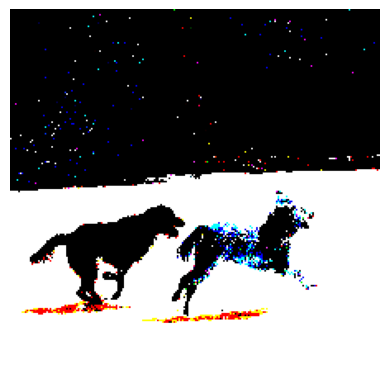

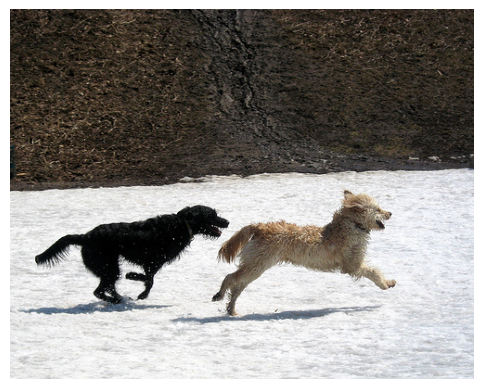

In [ ]:
img = preprocess_img(images_path + '2513260012_03d33305cf.jpg')
plt.imshow(img[0])
plt.axis('off')
plt.show()
img = plt.imread(images_path + '2513260012_03d33305cf.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
def encode_images(img_path):
    img = preprocess_img(img_path)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1, ))
    return feature_vector

encode_images(images_path + '2513260012_03d33305cf.jpg')

1/1 [==============================] - 0s 156ms/step


array([0.34707975, 0.5115912 , 0.08728842, ..., 1.1897293 , 0.04043853,
       0.1527104 ], dtype=float32)

In [ ]:
def encoding_data(data):
    start = time()
    encoding_train = {}

    for i, img_id in enumerate(data):
        encoding_train[img_id] = encode_images(images_path + img_id + '.jpg')
        if i%100 == 0:
            print('Encoding in progress %d step'%i)

    end_t = time()
    print("Total time taken: ",end_t - start)
    return encoding_train

In [ ]:
# train with resnet50 for all training images and obtain vector(2048,)

# encoding_train = encoding_data(train)
# encoding_test = encoding_data(test)

# with open('encoded_train_features.pkl', 'wb') as f:
#     pickle.dump(encoding_train, f)

# with open('encoded_test_features.pkl', 'wb') as f:
#     pickle.dump(encoding_test, f)

1/1 [==============================] - 0s 186ms/step
Encoding in progress 0 step
1/1 [==============================] - 0s 152ms/step
Encoding in progress 100 step
1/1 [==============================] - 0s 161ms/step
Encoding in progress 200 step
1/1 [==============================] - 0s 166ms/step
Encoding in progress 300 step
1/1 [==============================] - 0s 164ms/step
Encoding in progress 400 step
1/1 [==============================] - 0s 159ms/step
Encoding in progress 500 step
1/1 [==============================] - 0s 162ms/step
Encoding in progress 600 step
1/1 [==============================] - 0s 201ms/step
Encoding in progress 700 step
1/1 [==============================] - 0s 169ms/step
Encoding in progress 800 step
1/1 [==============================] - 0s 170ms/step
Encoding in progress 900 step
1/1 [==============================] - 0s 155ms/step
Total time taken:  233.6386833190918


In [ ]:
encoded_test_path = '/kaggle/input/encoded-features/encoded_features/encoded_test_features.pkl'
encoded_train_path = '/kaggle/input/encoded-features/encoded_features/encoded_train_features.pkl'

encoding_train, encoding_test = None, None

with open(encoded_train_path, 'rb') as f:
    encoding_train = pickle.load(f)


with open(encoded_test_path, 'rb') as f:
    encoding_test = pickle.load(f)


In [ ]:
word_2_idx = {}
idx_2_word = {}

for i, word in enumerate(Total_words):
    word_2_idx[word] = i + 1
    idx_2_word[i + 1] = word

print(word_2_idx['dog'])
print(idx_2_word[6])
print(idx_2_word[1846])
print(idx_2_word[1847])
print(word_2_idx['startseq'])

6
dog
startseq
endseq
1846


In [ ]:
max_len = 0
for values in train_descriptions.values():
    for sent in values:
        max_len = max(max_len, len(sent.split()))
print(max_len)

35


### **Word Embeddings**

In [ ]:
f = open('/kaggle/input/glove-embeddings/glove.6B.50d.txt')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype='float')
    embedding_index[word] = word_embedding

f.close()

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))

    for word, index in word_2_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[index] = embedding_vector

    return matrix


embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)


input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_img_features, input_captions], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def data_generator(train_descriptions, encoding_train, word_2_idx, max_len, batch_size=32):
    x1, x2, y = [],[],[]
    n = 0

    while True:
        for k, value_list in train_descriptions.items():
            n += 1
            photo = encoding_train[k]

            for sent in value_list:
                seq = [word_2_idx[w] for w in sent.split() if w in word_2_idx]

                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]

                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
#                     print("xi shape: ",np.array(xi).shape)
#                     print("yi shape: ",np.array(yi).shape)

                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
#                     print("x1 shape: ",np.array(x1).shape)
#                     print("x2 shape: ",np.array(x2).shape)
#                     print("y shape: ",np.array(y).shape)

            if n == batch_size:
                yield [np.array(x1), np.array(x2)], np.array(y)
                x1,x2,y = [],[],[]
                n = 0

In [ ]:
batch_size = 3
epochs = 20
steps = len(train_descriptions)

In [ ]:
def train():
    for e in range(epochs):
        generator = data_generator(train_descriptions, encoding_train, word_2_idx, max_len, batch_size)
        print("here: ", model.output_shape)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('/kaggle/working/models/models_'+str(e)+".h5")

# train()

here:  (None, 1848)
2623/6000 [============>.................] - ETA: 14:27 - loss: 4.1743

KeyboardInterrupt: 

In [ ]:
%%capture
model = load_model('/content/models_19.h5')

def predict_caption(photo, max_len, word_2_idx, idx_2_word):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_2_idx[w] for w in in_text.split() if w in word_2_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')[0]
        sequence = np.expand_dims(sequence, axis=0)
        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax(axis=-1)[0]
        word = idx_2_word[ypred]
        in_text += (' ' + word)
        if word == "endseq":
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 34ms/step


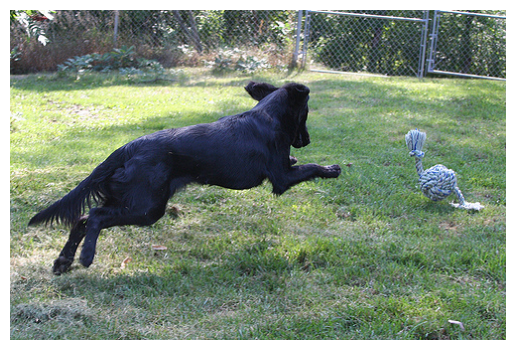

black dog is following the grass
1/1 [==============================] - 0s 31ms/step


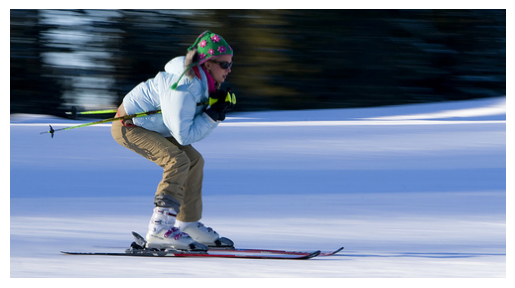

boy in red shirt and blue shorts is playing on swing
1/1 [==============================] - 0s 33ms/step


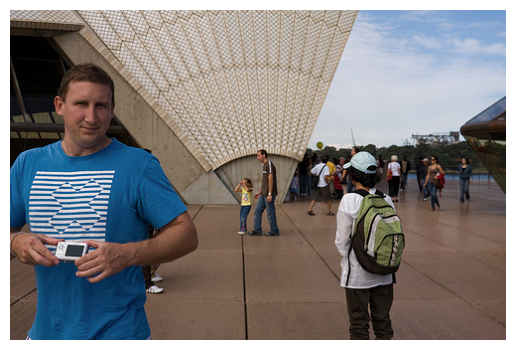

man in black shirt and cap is jogging unicycle
1/1 [==============================] - 0s 33ms/step


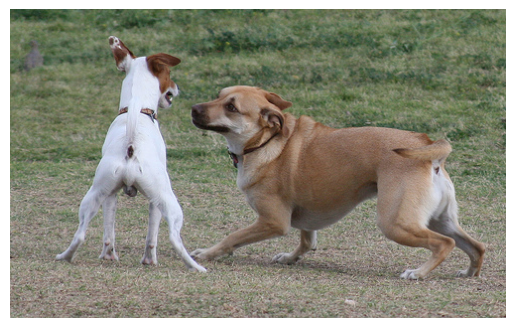

two dogs are running through field
1/1 [==============================] - 0s 59ms/step


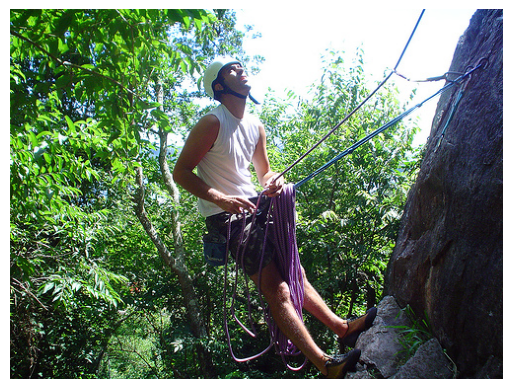

man in red shirt is climbing rock face
1/1 [==============================] - 0s 55ms/step


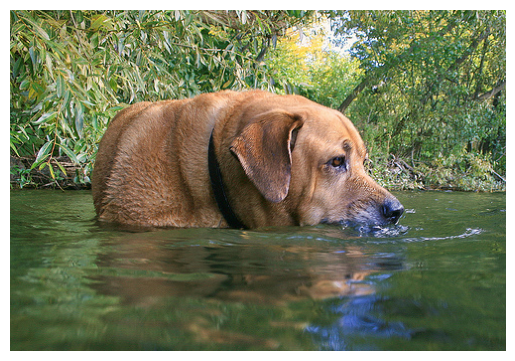

brown dog is running through the water
1/1 [==============================] - 0s 56ms/step


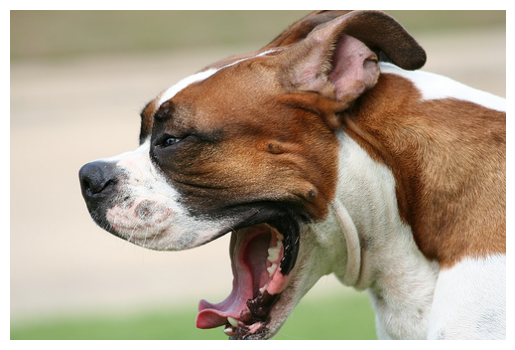

dog licks his lips
1/1 [==============================] - 0s 39ms/step


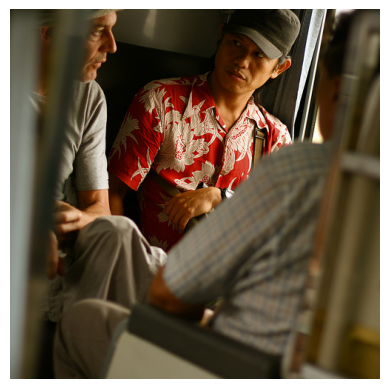

man in red shirt and tie is wearing gloves
1/1 [==============================] - 0s 41ms/step


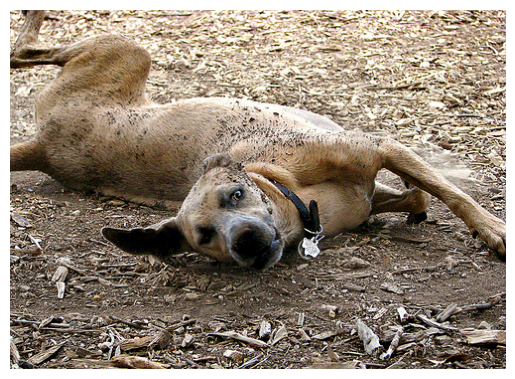

brown dog is drinking water from hose
1/1 [==============================] - 0s 44ms/step


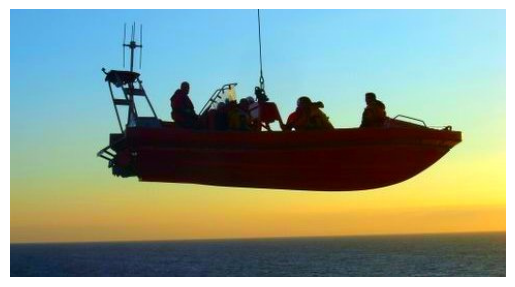

person in kayak is on the water
1/1 [==============================] - 0s 49ms/step


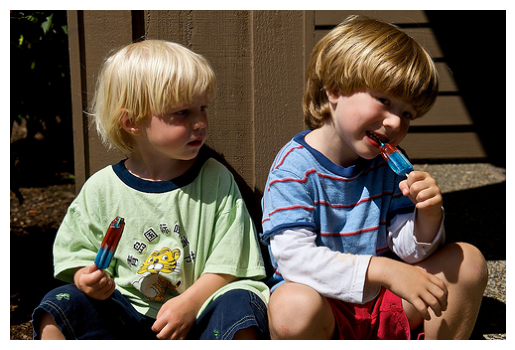

two girls are sitting on the grass
1/1 [==============================] - 0s 48ms/step


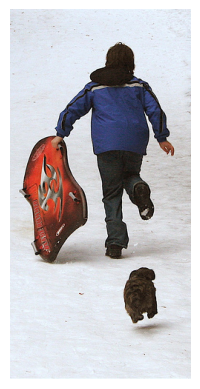

two men are sitting in snow
1/1 [==============================] - 0s 48ms/step


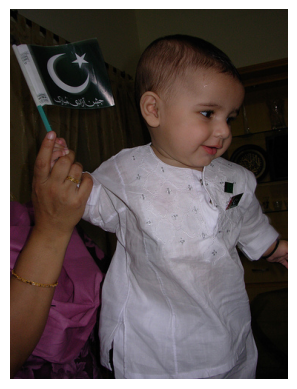

little girl in purple dress is holding her baby in her hand
1/1 [==============================] - 0s 45ms/step


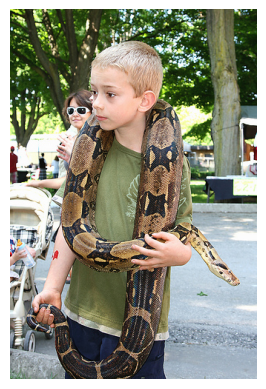

man in black shirt and gold cast wrestler mask
1/1 [==============================] - 0s 58ms/step


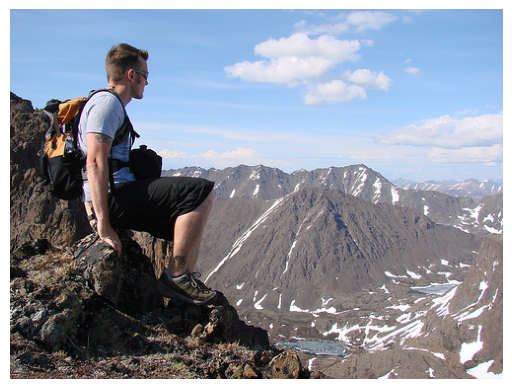

man in red shorts and khaki shorts is standing on rock overlooking valley


In [ ]:
for i in range(15):
    idx = np.random.randint(0, 1000)
    test_imgs = list(encoding_test.keys())
    test_img = test_imgs[idx]
    photo = encoding_test[test_img].reshape((1, 2048))
    img = plt.imread(images_path + test_img + '.jpg')
    caption = predict_caption(photo, max_len, word_2_idx, idx_2_word)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(caption)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model():
    actual, predicted = list(), list()
    k = 0
    for key, desc_list in descriptions.items():
        if encoding_train.get(key) is None:
          continue;
        photo = encoding_train[key].reshape((1, 2048))
        predicted_caption = predict_caption(photo, max_len, word_2_idx, idx_2_word)
        actual_caption = [d.split() for d in desc_list]
        actual.append(actual_caption)
        predicted.append(predicted_caption.split())
        k += 1
        print(k, end=' ')
        if k == 1000:
          break

    bleu_scores = {
        'BLEU-1': corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)),
        'BLEU-2': corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)),
        'BLEU-3': corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)),
        'BLEU-4': corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    }

    return bleu_scores

bleu_scores = evaluate_model()

1/1 [==============================] - 0s 35ms/step
1000 

In [ ]:
bleu_scores

{'BLEU-1': 0.4835940256380101,
 'BLEU-2': 0.30412277231596696,
 'BLEU-3': 0.22636128719871726,
 'BLEU-4': 0.12378833125232484}